<a href="https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/resources/dl201_pract_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# unpackAI DL201: Practical Week 1

| Week | Topic                             | Chapters                  |Assignment                                                             | Comments / Links |
|:----:|:----------------------------------|:--------------------------|:----------------------------------------------------------------------|:----------------|
| 1    | Warm-up Session                   |                           | No assignment                                                         | -
| 2    | Recap/Refresh SGD                 | Chapter 4, MNIST Basic    | Make a model using SGD for the full MNIST dataset. Built from scratch |https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/resources/04_mnist_full_set_sgd_with_gpu.ipynb 
|      |                                   | Chapter 5, Pet Breeds     | Read sections on Cross-Entropy Loss to use in your model. You may skip the rest|
| 3    | More on CV                        | Chapter 5, Pet Breeds     | Read notebook, run it and perform assignments at the bottom           |https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/05_pet_breeds.ipynb
|      | (Learn the theory)                | Chapter 6, Multi-Category | Read notebook, run it and perform assignments at the bottom           |https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/06_multicat.ipynb
|      |                                   | Chapter 7, Sizing and TTA | Read notebook, run it and perform assignments at the bottom           |https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/07_sizing_and_tta.ipynb
|4     | Bring together all CV             | All CV chapters           | MNIST Challenge against historical leaderboard                        |https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/resources/dl201_pract_1.ipynb
|      | (Practical Exercises)             | All CV chapters           | Take the model you trained in Ch 2, and use any methods learned to improve it.  | - 

## Assignment 1: MNIST Full Dataset - Challenge against historical leaderboard

Compare your skills at CV using MNIST and any tool you have at your disposal with fastai, with researchers who have used the same dataset since the late 1990s.

1. Build your model using MNIST full dataset and any architecture in fastai
2. Test several approached using all the tools at your disposal (architecture, learning rate, augmentation, other tricks)
3. Pick the one (few) model(s) with the lowest error rate
4. Test this (these) model(s) with the MNIST Test Dataset, and note the error rate.

## Selected Leaderboard
The table below lists the best error rates achieved each year. When a year is missing, it means no-one could beat the previous best score.


| Model Type         | Year | Error Rate (%) |
|--------------------|:----:|:----------:|
| SVMs               | 1998 | 12.00         |
| Convolutional nets | 1999 | 0.70        |
| SVMs               | 2002 | 0.56       |
| Convolutional nets | 2003 | 0.40        |
| Convolutional nets | 2006 | 0.39       |
| Neural Nets        | 2010 | 0.35       |
| Convolutional nets | 2011 | 0.27       |
| Convolutional nets | 2012 | 0.23       |
| Neural Nets        | 2013 | 0.21       |
| New Neural Nets    | 2018 | 0.18       |
| Convolutional nets | 2020 | 0.17       |
| Convolutional nets | 2020 | 0.16       |
| Convolutional nets | 2020 | 0.16       |
| New Neural Nets    | 2021 | 0.16       |

From which year is your model ?

## Load full dataset

We are try to rerun the two classifiers built before to classify images as a 3 or a 7, but using the full dataset with 10 digits. So let's download the full MNIST datasets:

In [ ]:
path = untar_data(URLs.MNIST)    # Full dataset (0s to 9s)

In [ ]:
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [ ]:
path.ls(), (path / 'training').ls(), (path / 'testing').ls()

((#2) [Path('training'),Path('testing')],
 (#10) [Path('training/2'),Path('training/0'),Path('training/8'),Path('training/7'),Path('training/3'),Path('training/6'),Path('training/5'),Path('training/1'),Path('training/4'),Path('training/9')],
 (#10) [Path('testing/2'),Path('testing/0'),Path('testing/8'),Path('testing/7'),Path('testing/3'),Path('testing/6'),Path('testing/5'),Path('testing/1'),Path('testing/4'),Path('testing/9')])

## Create your DataBlock and Dataloaders for training

The code below is just an illustration, and not optimized. Use your own code to train the best model you can using all the tricks you have learned since Chapter 1.

In [ ]:
mnist = DataBlock(blocks=(ImageBlock,CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2),
                  get_y=parent_label)

In [ ]:
# mnist.summary(path/'training')

In [ ]:
dls = mnist.dataloaders(path/'training')

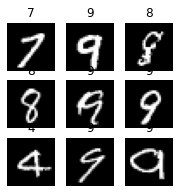

In [ ]:
dls.show_batch(max_n=9, figsize=(3, 3))

In [ ]:
learn = cnn_learner(dls, arch=resnet18, metrics=[error_rate, accuracy])

lr_min: 1.2e-02   lr_steep: 3.6e-03


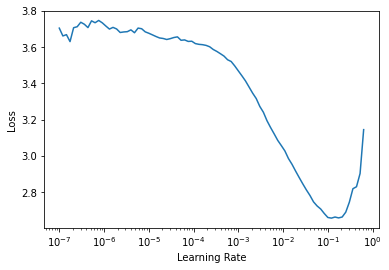

In [ ]:
lr_min, lr_steep = learn.lr_find()
print(f"lr_min: {lr_min:.1e}   lr_steep: {lr_steep:.1e}")

In [ ]:
lr = 1.5e-2
# learn.fine_tune(base_lr=lr, epochs=8, freeze_epochs=2)
learn.fit_one_cycle(n_epoch=3, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.230888,0.238648,0.063000,0.937000,00:59
1,0.101137,0.055547,0.016917,0.983083,00:58
2,0.059918,0.031999,0.010250,0.989750,00:58


lr_min: 6.9e-07   lr_steep: 9.1e-07


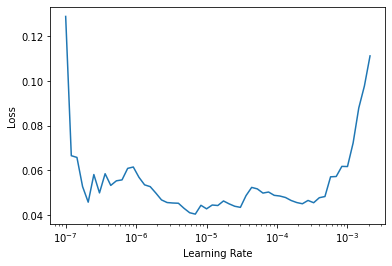

In [ ]:
learn.unfreeze()

lr_min, lr_steep = learn.lr_find()
print(f"lr_min: {lr_min:.1e}   lr_steep: {lr_steep:.1e}")

In [ ]:
lr = 2e-5
learn.fit_one_cycle(n_epoch=8, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.056564,0.029790,0.010250,0.989750,01:01
1,0.042597,0.029020,0.008833,0.991167,01:01
2,0.033641,0.025280,0.008000,0.992000,01:03
3,0.026498,0.023639,0.006667,0.993333,01:03
4,0.018085,0.022234,0.006000,0.994000,01:03
5,0.014426,0.020288,0.006000,0.994000,01:04
6,0.016236,0.020625,0.005667,0.994333,01:03
7,0.009436,0.020033,0.006000,0.994000,01:02


## Evaluate model with Testing Dataset

Now that you have a model, it is time to test it with the Testing Dataset, for proper comparison.

To do that, we also want to apply exactly the same steps with the test images as withe training images. Therefore we do not recreate a DataBlock and DataLoaders from scratch, but we use the training DataLoaders `dls` and its method `test_dl` to do that.

Steps:
1. Create a list of test images
2. Create a `dls_test` with these images, using `dls.test_df()`
3. Evaluate the test set

In [ ]:
# Create a list of test images using all images in 
test_image_fnames = get_image_files(path/'testing')
test_image_fnames

(#10000) [Path('testing/2/3057.png'),Path('testing/2/690.png'),Path('testing/2/3599.png'),Path('testing/2/8139.png'),Path('testing/2/2184.png'),Path('testing/2/4905.png'),Path('testing/2/9716.png'),Path('testing/2/8318.png'),Path('testing/2/278.png'),Path('testing/2/2959.png')...]

In [ ]:
# Create the dataloader for test images
test_dl = dls.test_dl(test_image_fnames, with_labels=True)

With `test_dl`, we can access some basic info such as the number of samples, number of classes and views of images

In [ ]:
test_dl.n

10000

In [ ]:
test_dl.c

10

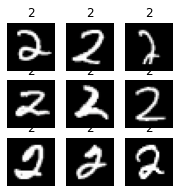

In [ ]:
test_dl.show_batch(max_n=9, figsize=(3, 3))

In [ ]:
preds_test_set = learn.get_preds(dl=test_dl)

In [ ]:
preds_test_set

(tensor([[3.3559e-07, 2.5453e-07, 1.0000e+00,  ..., 8.1596e-07, 3.3991e-07, 6.2838e-07],
         [2.1795e-07, 4.7057e-07, 9.9999e-01,  ..., 2.3675e-06, 1.0488e-06, 5.2655e-07],
         [1.0372e-06, 1.0628e-05, 9.9992e-01,  ..., 6.4257e-05, 3.9671e-06, 1.1932e-06],
         ...,
         [2.2645e-07, 1.0614e-07, 1.4804e-07,  ..., 6.9798e-07, 6.6576e-06, 9.9990e-01],
         [9.7591e-07, 5.1720e-07, 7.4489e-06,  ..., 3.5174e-06, 1.5716e-04, 9.9976e-01],
         [9.6762e-07, 9.6399e-08, 1.1938e-07,  ..., 1.7255e-06, 2.8185e-05, 9.9994e-01]]),
 TensorCategory([2, 2, 2,  ..., 9, 9, 9]))

In [ ]:
test_results = learn.validate(dl=test_dl)

`.validate()` return the following values:
- loss function for the dataset
- metric(s) applied to the dataset

In the case of the example above:
- loss function
- error_rate
- accuracy

In [ ]:
print(f"Loss Function: {test_results[0]*100:.3f}%")
for i, m in enumerate(learn.metrics):
    print(f"{m.name}: {test_results[i+1]*100:.3f}%")

Loss Function: 2.048%
error_rate: 0.700%
accuracy: 99.300%


| Model Type         | Year | Error Rate (%) | My Basic Model
|--------------------|:----:|:----------:|:----:|
| SVMs               | 1998 | 12.00         |
| Convolutional nets | 1999 | 0.70        | HERE :-(
| SVMs               | 2002 | 0.56       |
| Convolutional nets | 2003 | 0.40        |
| Convolutional nets | 2006 | 0.39       |
| Neural Nets        | 2010 | 0.35       |
| Convolutional nets | 2011 | 0.27       |
| Convolutional nets | 2012 | 0.23       |
| Neural Nets        | 2013 | 0.21       |
| New Neural Nets    | 2018 | 0.18       |
| Convolutional nets | 2020 | 0.17       |
| Convolutional nets | 2020 | 0.16       |
| Convolutional nets | 2020 | 0.16       |
| New Neural Nets    | 2021 | 0.16       |